In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools

In [2]:
f_sig = "signal_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    "QCD":"bkg_2018_QCD_TuneCP5_PSWeights_ejdR_rejection_IDcut.coffea",
    "Top":"bkg_2018_Top_ejdR_rejection_IDcut.coffea",
    "DY":"bkg_2018_DY_ejdR_rejection_IDcut.coffea",
    "Diboson":"bkg_2018_Diboson_ejdR_rejection_IDcut.coffea",
    "Triboson":"bkg_2018_Triboson_ejdR_rejection_IDcut.coffea",
    "W+jets":"bkg_2018_WJets_ejdR_rejection_IDcut.coffea",
    "Z+jets":"bkg_2018_ZJets_ejdR_rejection_IDcut.coffea"
}
bkg_histos = {}
histograms = []
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['QCD'][h]) == hist.Hist and bkg_histos['QCD'][h].sum(flow=True).value > 0:
        bkg[h] = {b:bkg_histos[b][h][{"samp":sum}] for b in bkg_histos.keys()}

In [3]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))
cutSel = 'cut7'

In [4]:
from matplotlib.colors import LogNorm
def plot(samp,hname,rebinx,rebiny,xlim,ylim,cut=cutSel):
    ctaus = [1,10,100,1000]
    for ct in ctaus:
        hs = sig[hname][{"samp":f"{samp}_ctau-{ct}","cut":cut}][::rebinx,::rebiny]
        hb = sum([bkg[hname][k] for k in bkg[hname].keys()])[{"cut":cut}][::rebinx,::rebiny]
        vmin = min(hs.values()[hs.values()>0].min(),hb.values()[hb.values()>0].min())
        vmax = max(hs.values()[hs.values()>0].max(),hb.values()[hb.values()>0].max())
        plt.figure(figsize=(10,5))
        plt.subplot(121)
        hs.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
        #cb = plt.gca().images[-1].colorbar
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.subplot(122)
        hb.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.tight_layout()

In [6]:
from matplotlib.colors import LogNorm
def plotbkg(samp,hname,rebinx,rebiny,xlim,ylim,cut=cutSel):
    hb = sum([bkg[hname][k] for k in bkg[hname].keys()])[{"cut":cut}][::rebinx,::rebiny]
    vmin = hb.values()[hb.values()>0].min()
    vmax = hb.values()[hb.values()>0].max()
    plt.figure(figsize=(5,5))
    hb.plot2d(norm=LogNorm(vmin=vmin,vmax=vmax),cmap='plasma')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()

In [7]:
from matplotlib.colors import LogNorm
def plot_SoverB(samp,hname,rebinx,rebiny,cut=cutSel,forwardX=True,forwardY=True,xlabel="",ylabel="",m="",dm=""):
    ctaus = [1,10,100,1000]
    hb = sum([bkg[hname][k] for k in bkg[hname].keys()])[{"cut":cut}][::rebinx,::rebiny]
    x = hb.axes[0].edges
    y = hb.axes[1].edges
    ratios = {}
    vmax = 0
    vmin = 999999.0
    for i,ct in enumerate(ctaus):
        hs = sig[hname][{"samp":f"{samp}_ctau-{ct}","cut":cut}][::rebinx,::rebiny]
        cs = hs.values(flow=True)
        cb = hb.values(flow=True)
        ratio = np.zeros((cs.shape[0]-2,cs.shape[1]-2))
        for k in range(1,cs.shape[0]-1):
            for j in range(1,cs.shape[1]-1):
                if forwardX and forwardY:
                    ns = np.sum(cs[k:,j:])
                    nb = np.sum(cb[k:,j:])
                elif not forwardX and forwardY:
                    ns = np.sum(cs[:k,j:])
                    nb = np.sum(cb[:k,j:])
                elif forwardX and not forwardY:
                    ns = np.sum(cs[k:,:j])
                    nb = np.sum(cb[k:,:j])
                else:
                    ns = np.sum(cs[:k,:j])
                    nb = np.sum(cb[:k,:j])
                if nb == 0 and ns > 0:
                    ratio[k-1,j-1] = np.inf
                elif nb == 0 and ns == 0:
                    ratio[k-1,j-1] = 0
                else:
                    ratio[k-1,j-1] = ns/np.sqrt(nb)
        ratios[ct] = np.copy(ratio)
        if np.max(ratio[ratio!=np.inf]) > vmax:
            vmax = np.max(ratio[ratio!=np.inf])
        if len(ratio[ratio>0])>0 and np.min(ratio[ratio>0]) < vmin:
            vmin = np.min(ratio[ratio>0])
    
    plt.figure(figsize=(16,4))
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=vmin,vmax=vmax)
    for i,ct in enumerate(ctaus):
        plt.subplot(1,4,i+1)
        ratio = ratios[ct]
        ratio[ratio==np.inf] = vmax
        plt.title(f"$c\\tau = {int(ct)}$ mm",fontsize=14)
        plt.imshow(ratio.T,extent=[x[0],x[-1],y[0],y[-1]],aspect='auto',origin='lower',norm=norm,cmap='plasma')
        plt.xlabel(xlabel,fontsize=14)
        plt.ylabel(ylabel,fontsize=14)
    plt.colorbar()
    plt.suptitle(r"$(m,\Delta) = ({0:.1f},{1:.1f})$".format(m,dm),fontsize=16)
    plt.tight_layout()
    if not os.path.exists(f"plots/ABCD/{hname}/"):
        os.mkdir(f"plots/ABCD/{hname}/")
    plt.savefig(f"plots/ABCD/{hname}/signif_m1-{m}_delta-{dm}.pdf")
    plt.close()

In [131]:
from tqdm import tqdm
for delta in deltas:
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for m1 in tqdm(m1s):
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==10)].name[0][:-8]
        
        plot_SoverB(point,"sel_vtx_maxPFIso_vs_mindxy",
                1j,1j,cut='cut7',forwardX=False,forwardY=True,
                    m=m1,dm=delta,xlabel="$I_\mathrm{PF}^\mathrm{rel}$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_mindxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_vxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(e^+e^-,MET)$",ylabel="$v_{xy}$")
        
        plot_SoverB(point,"sel_vtx_mindRj_vs_mindxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
        
        plot_SoverB(point,"sel_vtx_mindPhiJ_vs_mindxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
            
        plot_SoverB(point,"sel_vtx_mindRj_vs_maxPFIso",
                1j,1j,cut='cut7',forwardX=True,forwardY=False,
                    m=m1,dm=delta,xlabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$")
        
        plot_SoverB(point,"sel_vtx_mindPhiJ_vs_maxPFIso",
                1j,1j,cut='cut7',forwardX=True,forwardY=False,
                    m=m1,dm=delta,xlabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$")
        
        ####
        
        plot_SoverB(point,"sel_vtx_minEledRj_vs_mindxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
        
        plot_SoverB(point,"sel_vtx_minEledPhiJ_vs_mindxy",
                1j,1j,cut='cut7',forwardX=True,forwardY=True,
                    m=m1,dm=delta,xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$\min(d_{xy,1},d_{xy,2})$")
            
        plot_SoverB(point,"sel_vtx_minEledRj_vs_maxPFIso",
                1j,1j,cut='cut7',forwardX=True,forwardY=False,
                    m=m1,dm=delta,xlabel="$\min(\Delta R(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$")
        
        plot_SoverB(point,"sel_vtx_minEledPhiJ_vs_maxPFIso",
                1j,1j,cut='cut7',forwardX=True,forwardY=False,
                    m=m1,dm=delta,xlabel="$\min(\Delta \phi(e,\mathrm{jets}))$",ylabel="$I_\mathrm{PF}^\mathrm{rel}$")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:08<00:00, 52.58s/it]


In [15]:
from tqdm import tqdm
for delta in deltas:
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for m1 in tqdm(m1s):
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==10)].name[0][:-8]
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_mindPhiJ",
                1j,1j,cut='cut7',forwardX=False,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(MET,e^+e^-)$",ylabel="$\min(\Delta \phi(e^+e^-,\mathrm{jets}))$")
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_mindRj",
                1j,1j,cut='cut7',forwardX=False,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(MET,e^+e^-)$",ylabel="$\min(\Delta R(e^+e^-,\mathrm{jets}))$")
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_minEledPhiJ",
                1j,1j,cut='cut7',forwardX=False,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(MET,e^+e^-)$",ylabel="$\min(\Delta \phi(e_1,\mathrm{jets}),\Delta \phi(e_2,\mathrm{jets}))$")
        
        plot_SoverB(point,"sel_vtx_METdPhi_vs_minEledRj",
                1j,1j,cut='cut7',forwardX=False,forwardY=True,
                    m=m1,dm=delta,xlabel="$\Delta \phi(MET,e^+e^-)$",ylabel="$\min(\Delta R(e_1,\mathrm{jets}),\Delta R(e_2,\mathrm{jets}))$")

100%|█████████████████████████████████████████████| 7/7 [00:27<00:00,  3.97s/it]


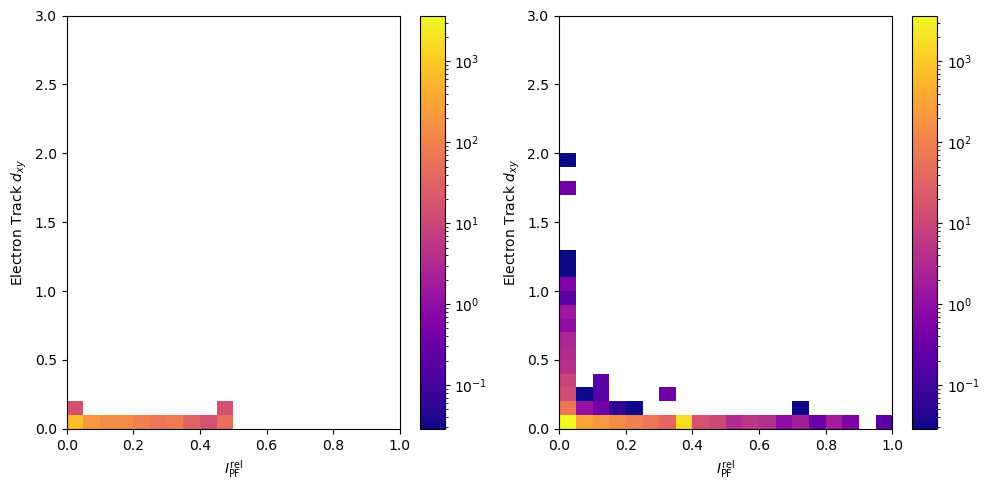

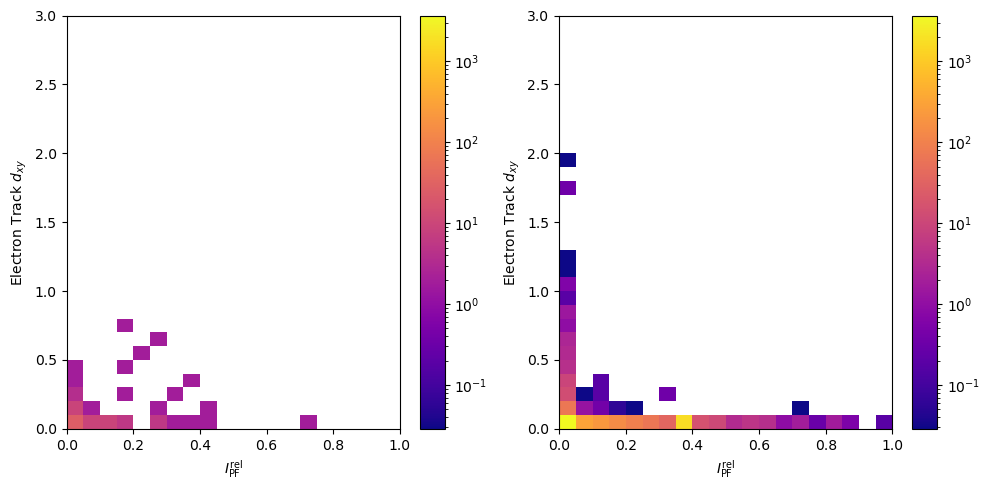

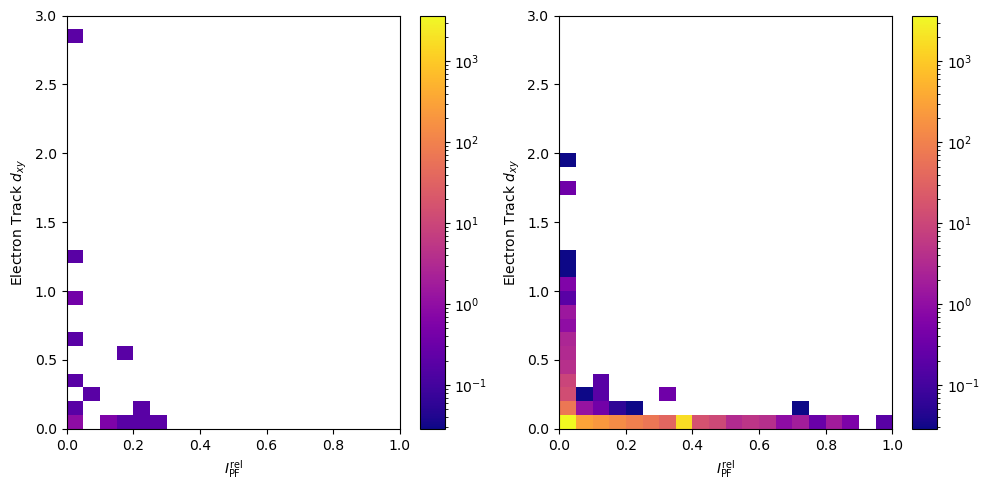

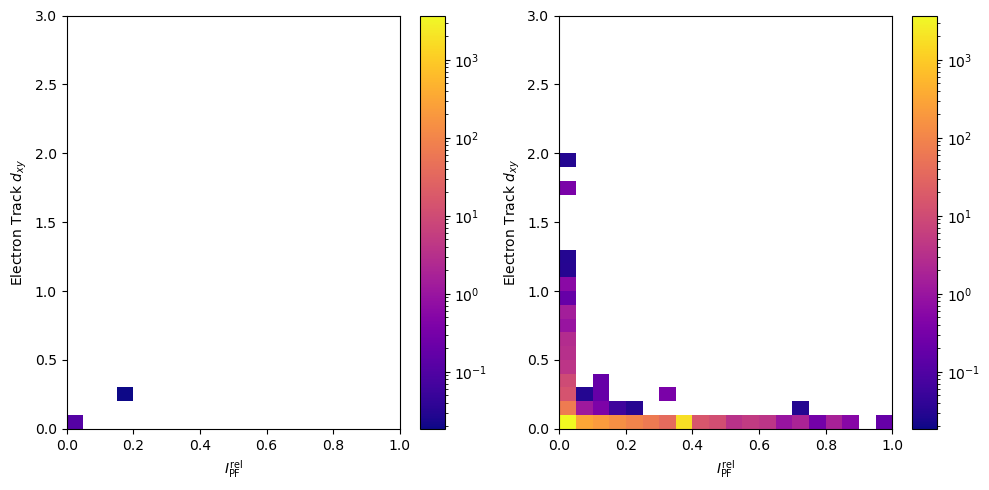

In [7]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_maxPFIso_vs_mindxy",1j,1j,xlim=[0,1],ylim=[0,3])

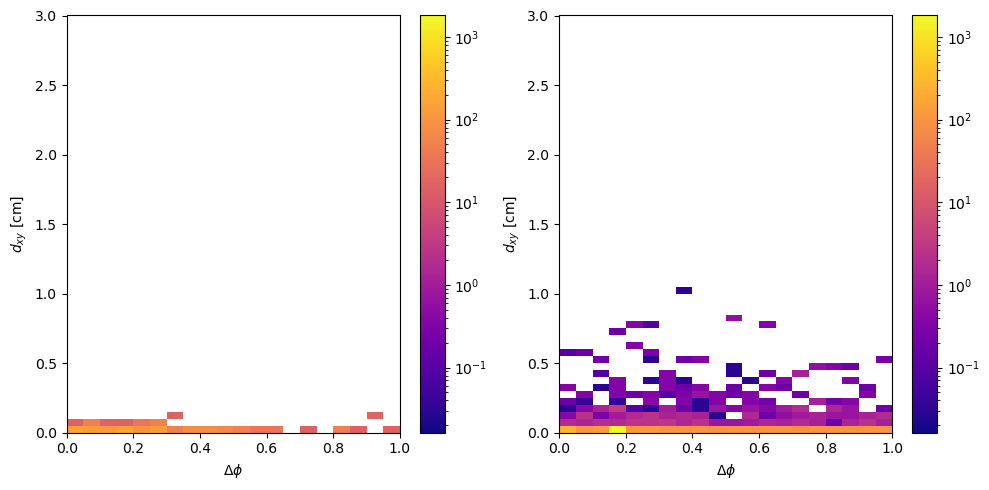

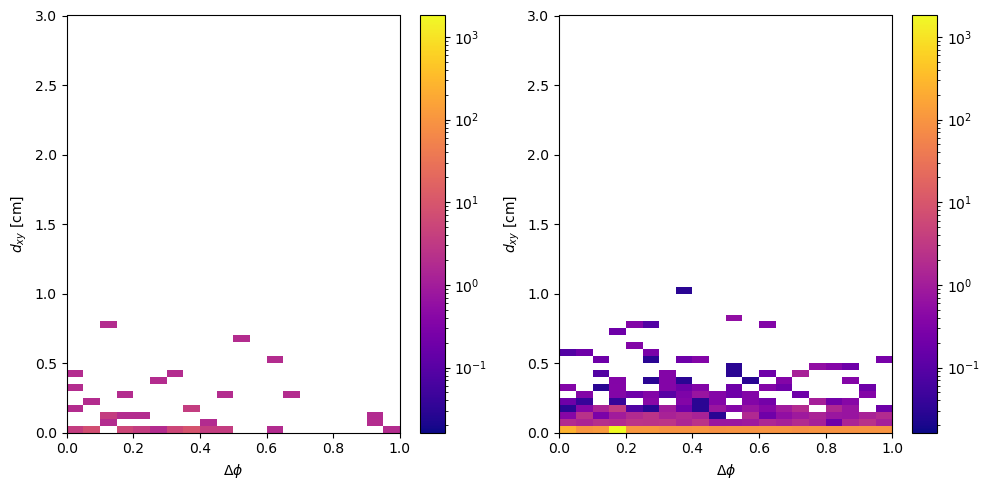

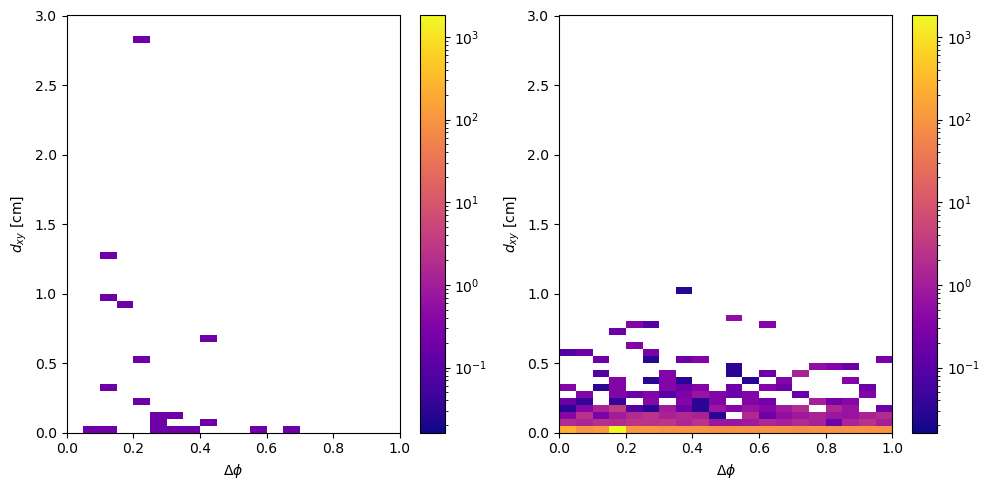

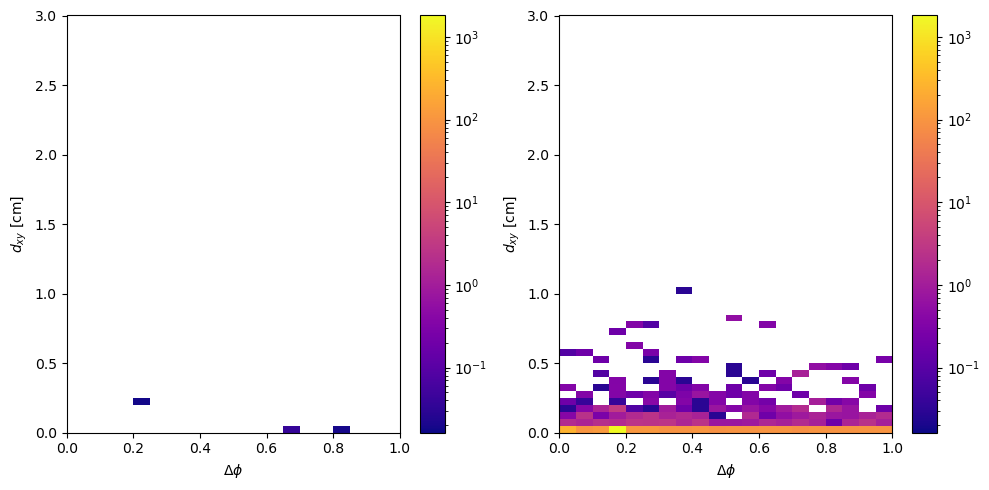

In [8]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_METdPhi_vs_mindxy",1j,1j,xlim=[0,1],ylim=[0,3])

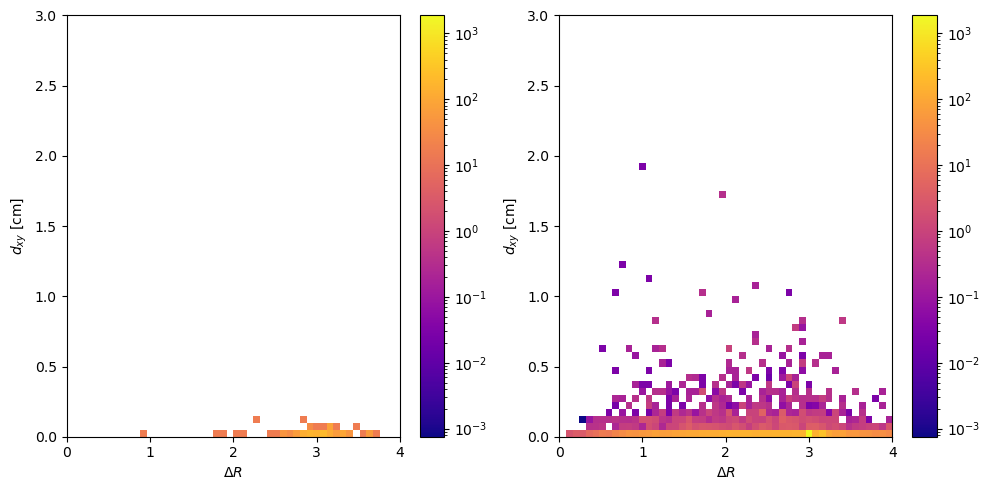

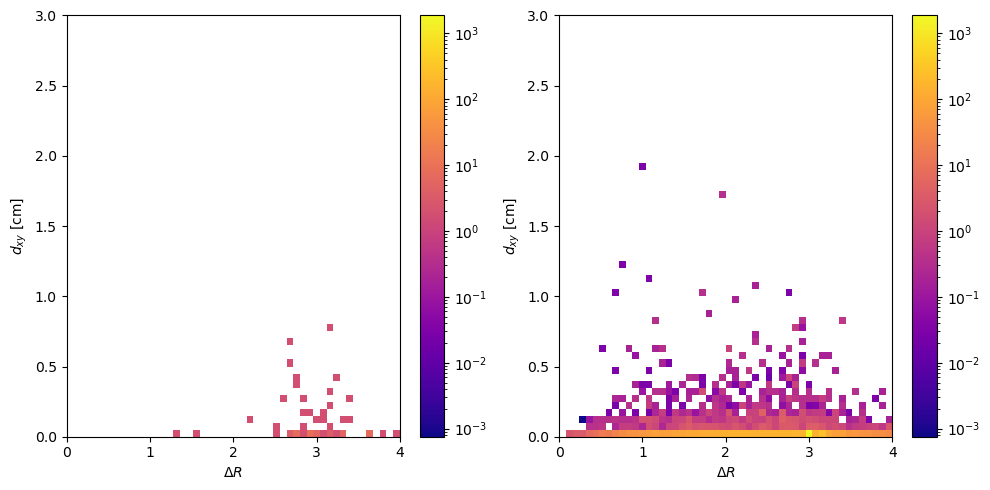

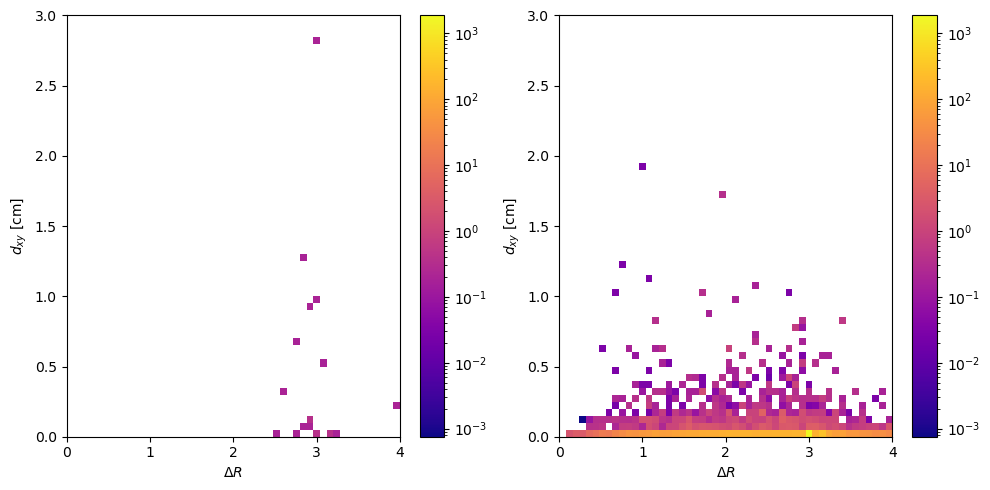

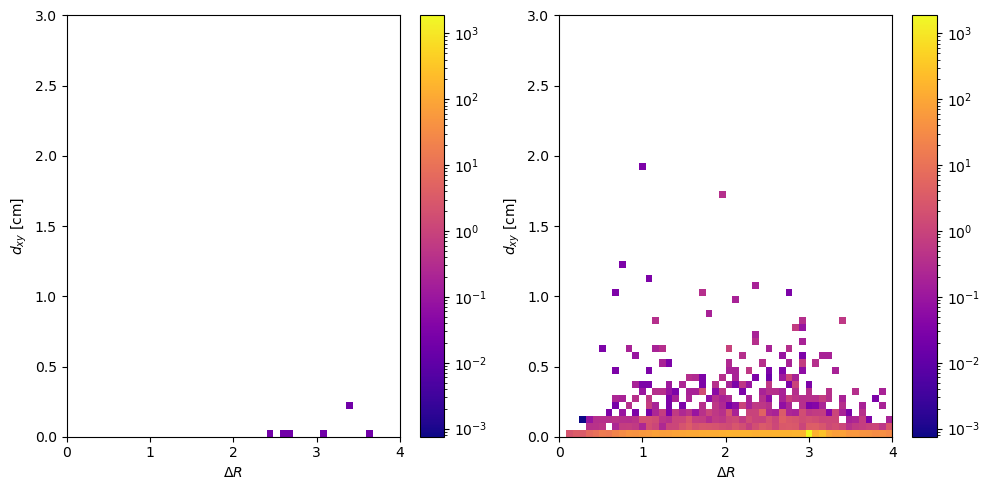

In [11]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_mindRj_vs_mindxy",2j,1j,xlim=[0,4],ylim=[0,3])

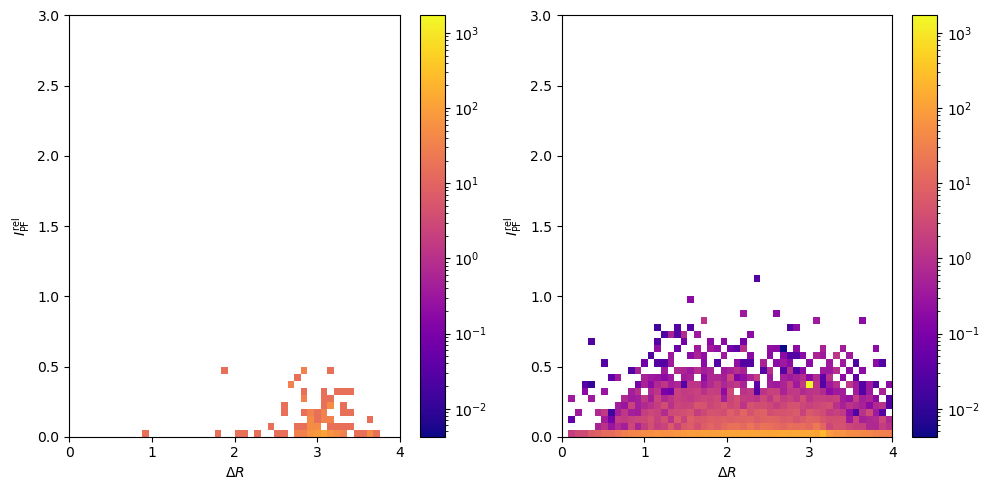

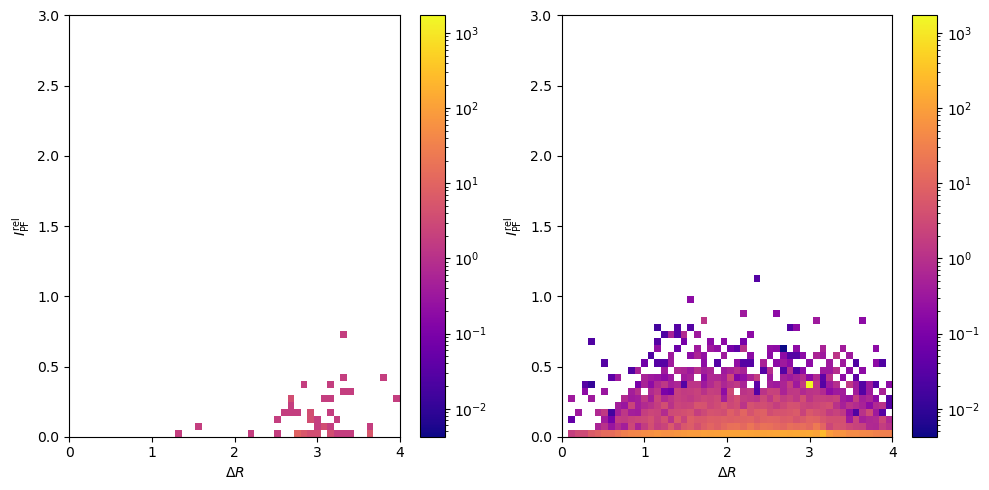

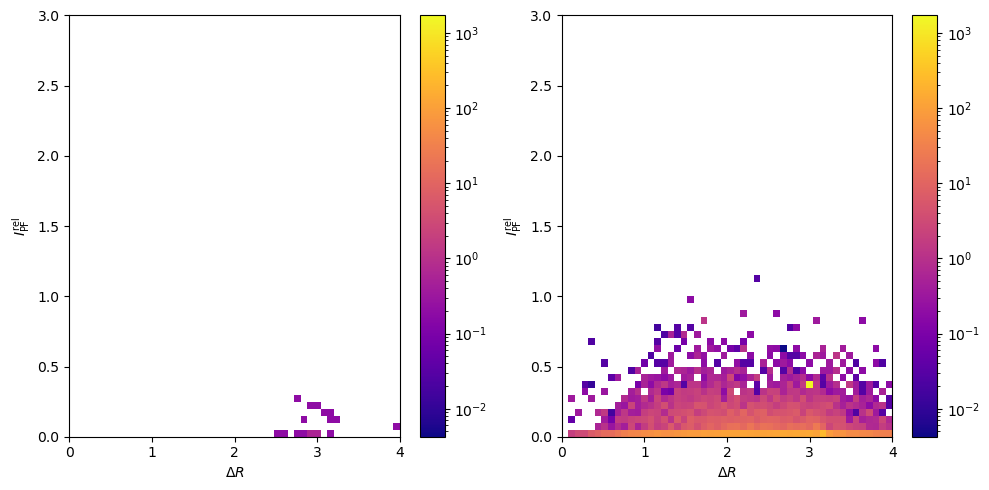

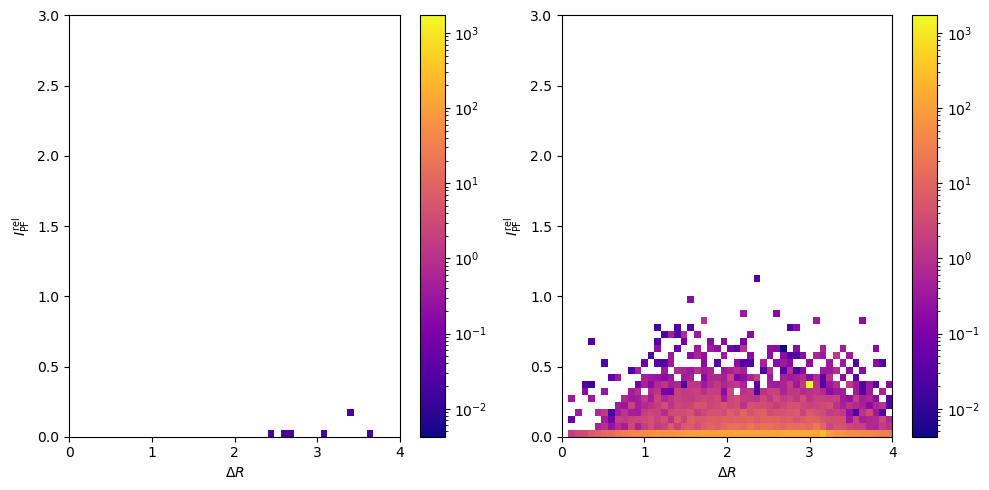

In [12]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_mindRj_vs_maxPFIso",2j,1j,xlim=[0,4],ylim=[0,3])

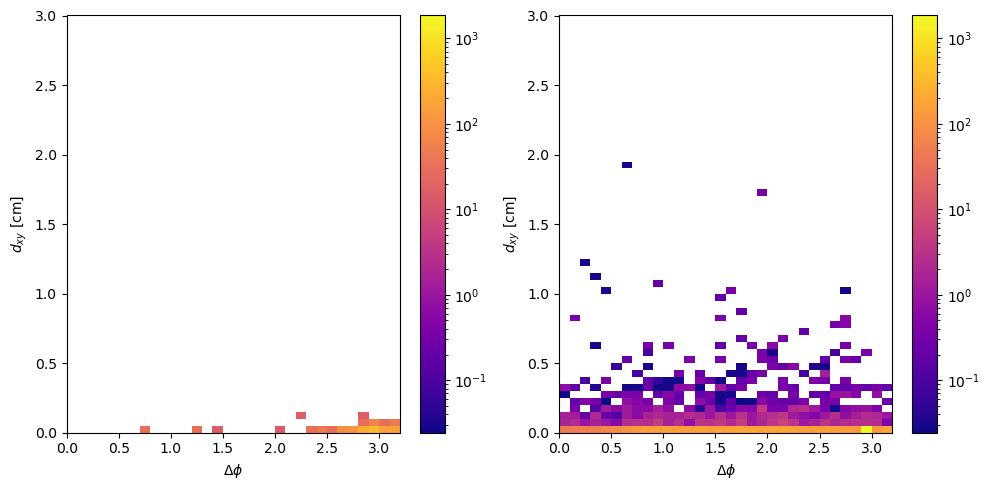

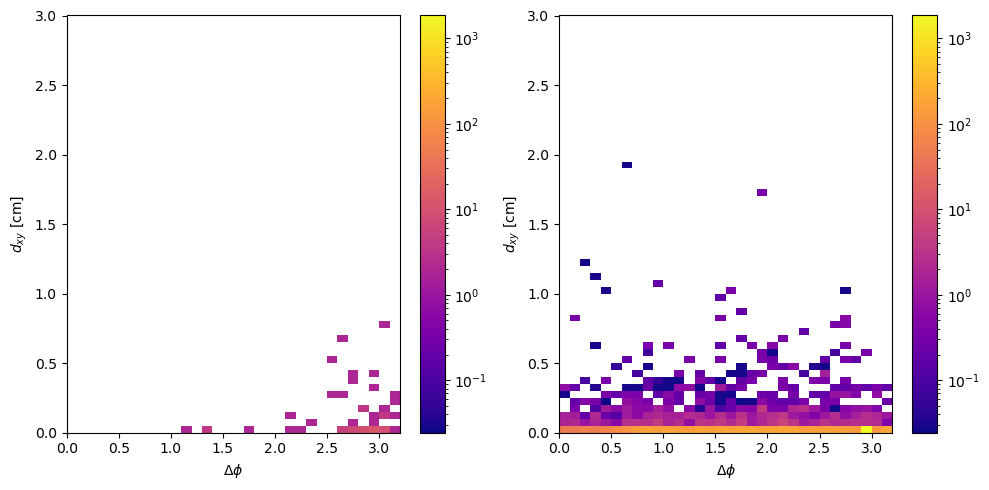

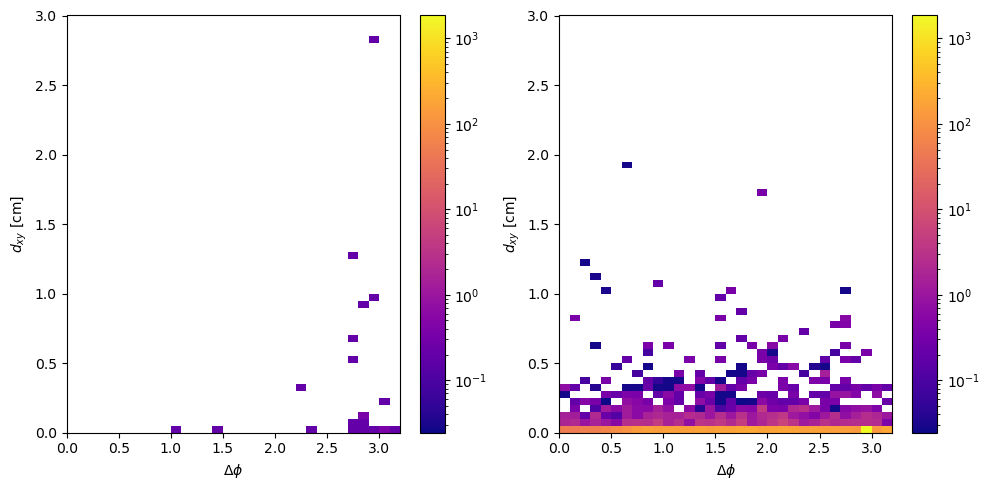

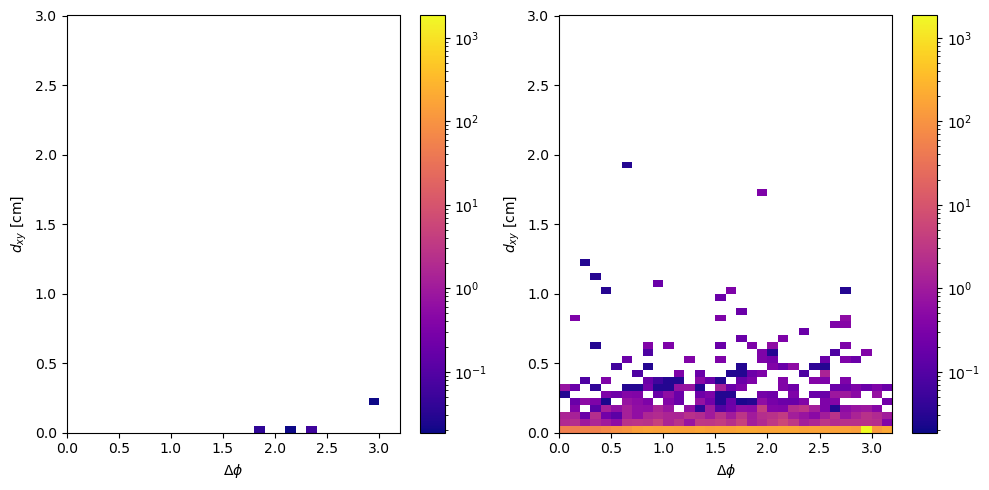

In [13]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_mindPhiJ_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

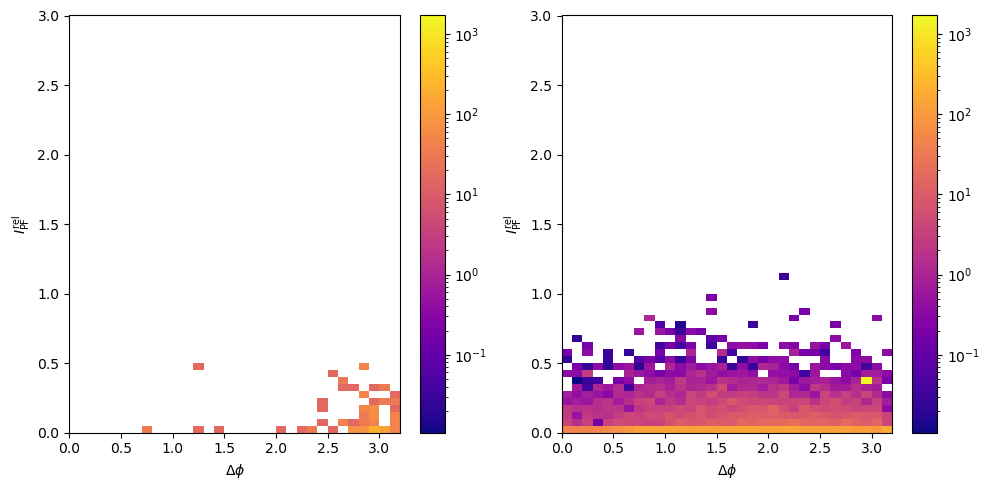

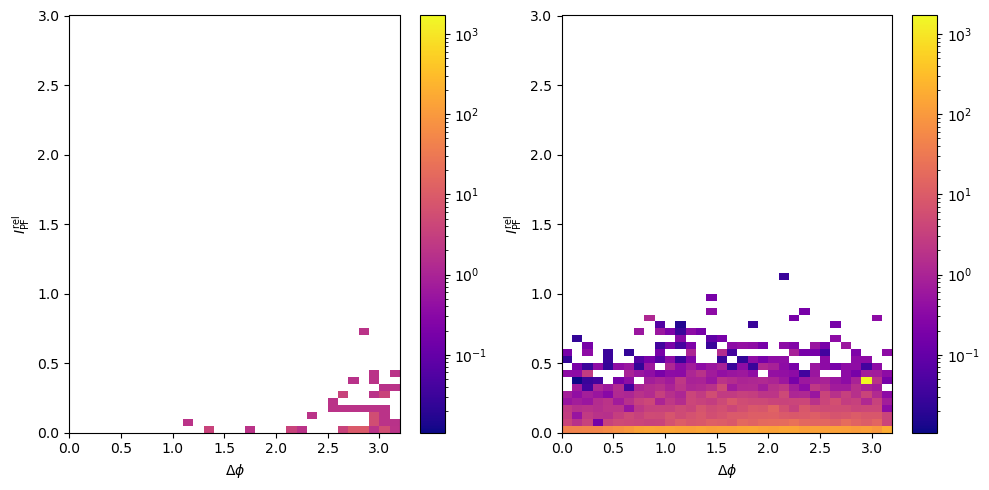

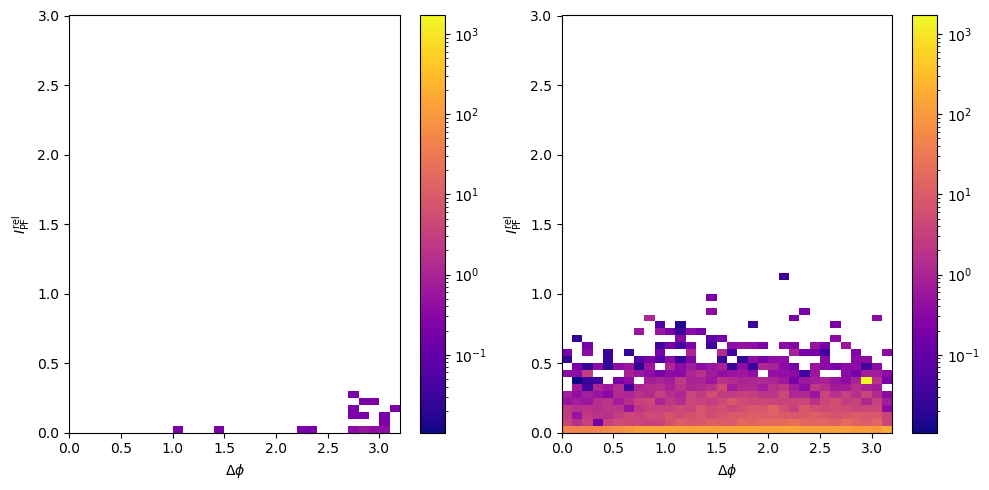

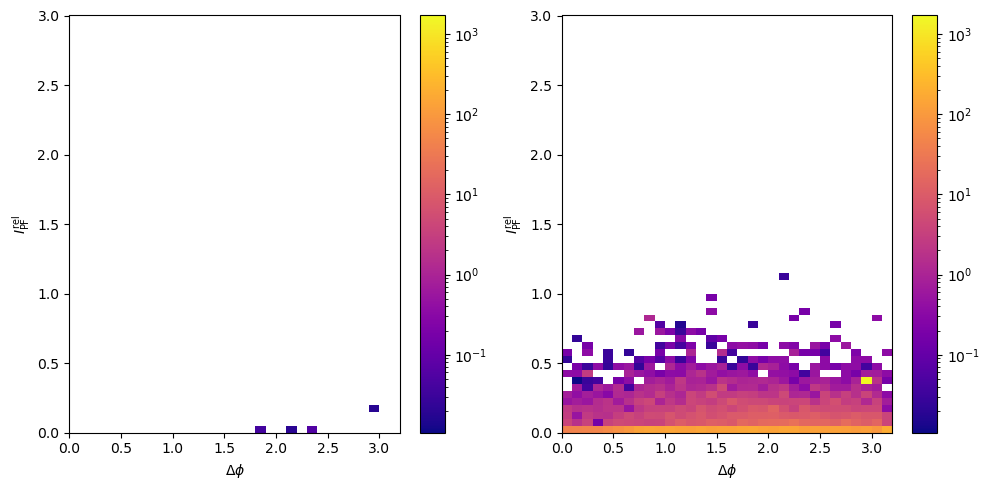

In [14]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_mindPhiJ_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

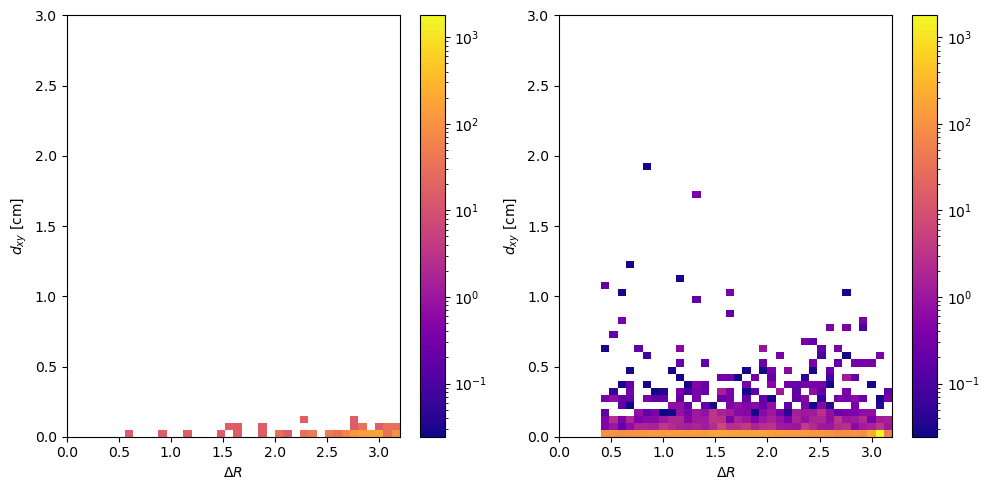

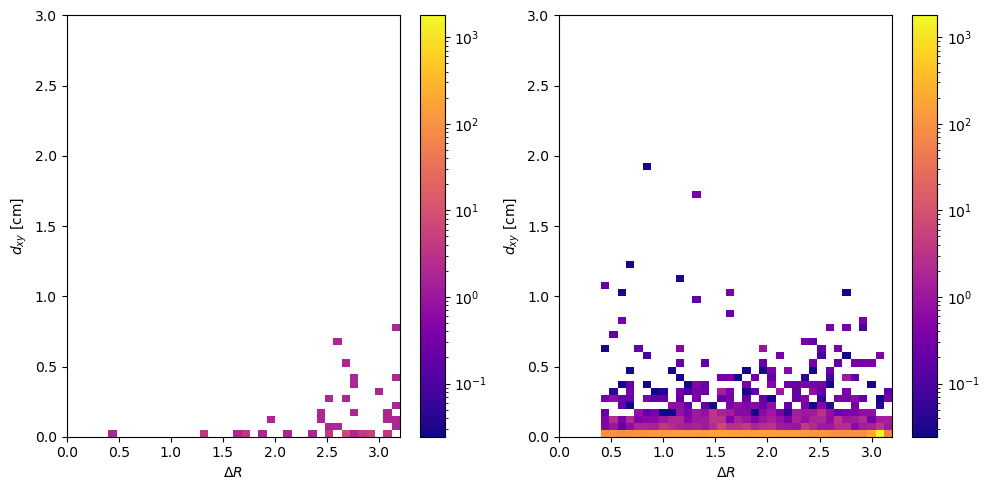

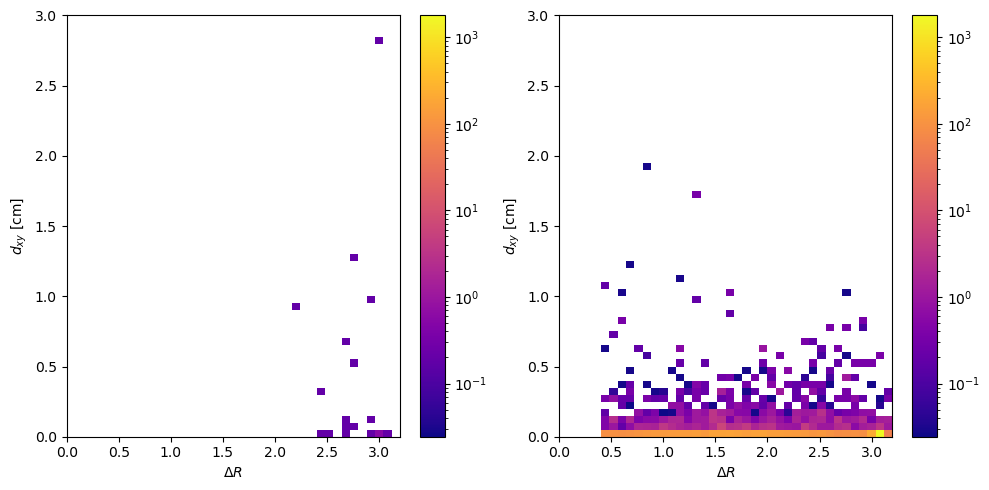

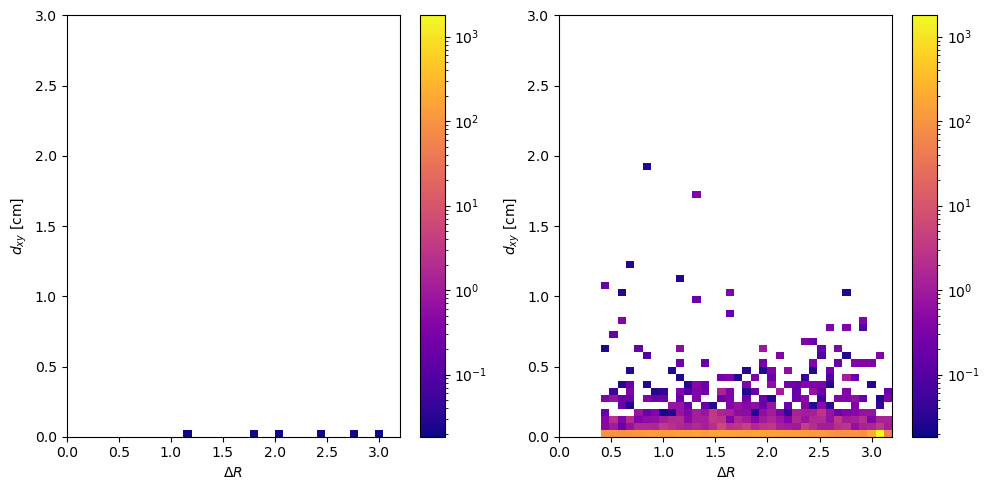

In [15]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_minEledRj_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

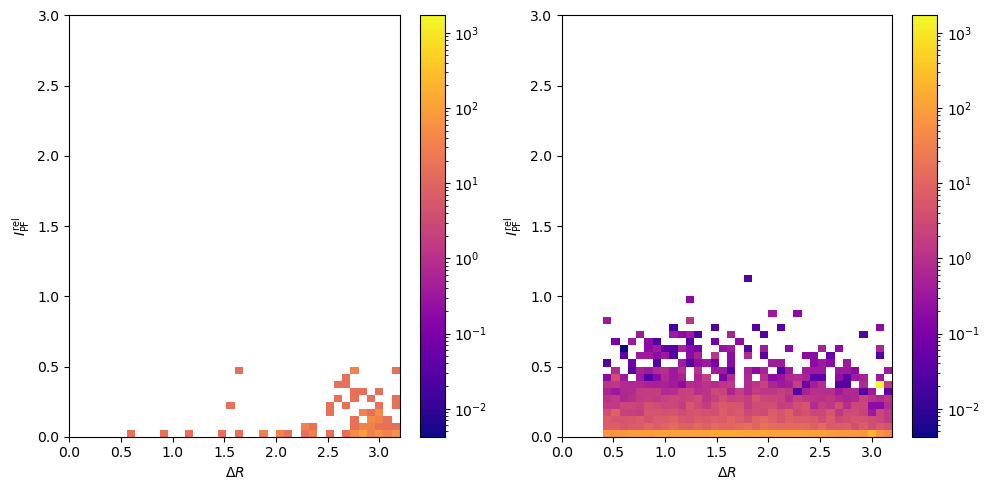

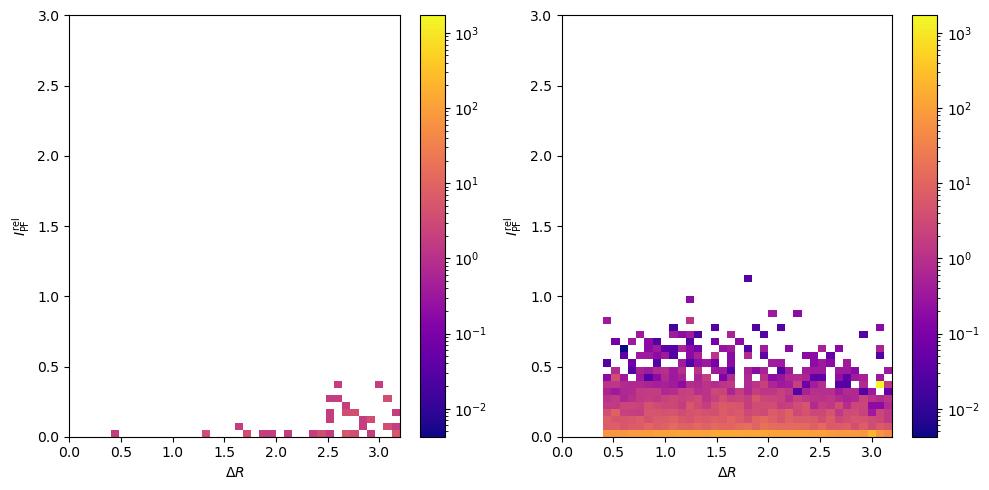

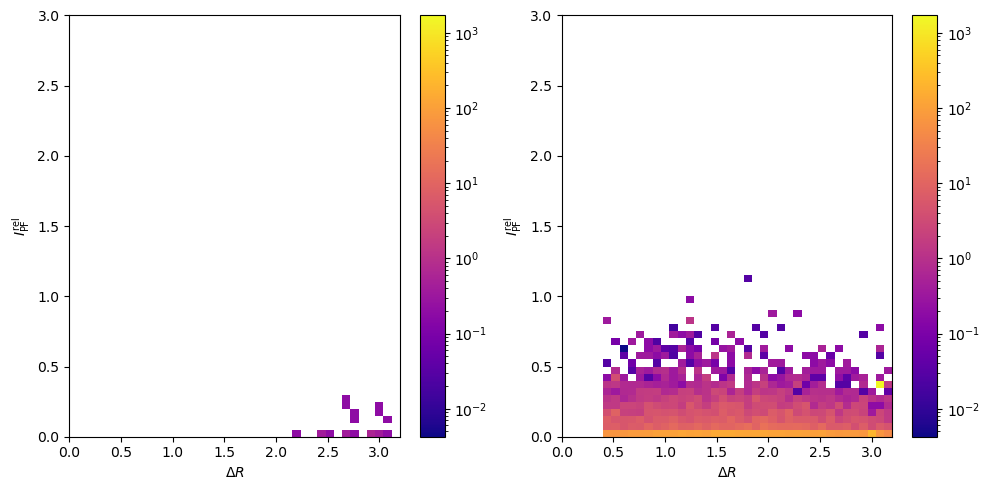

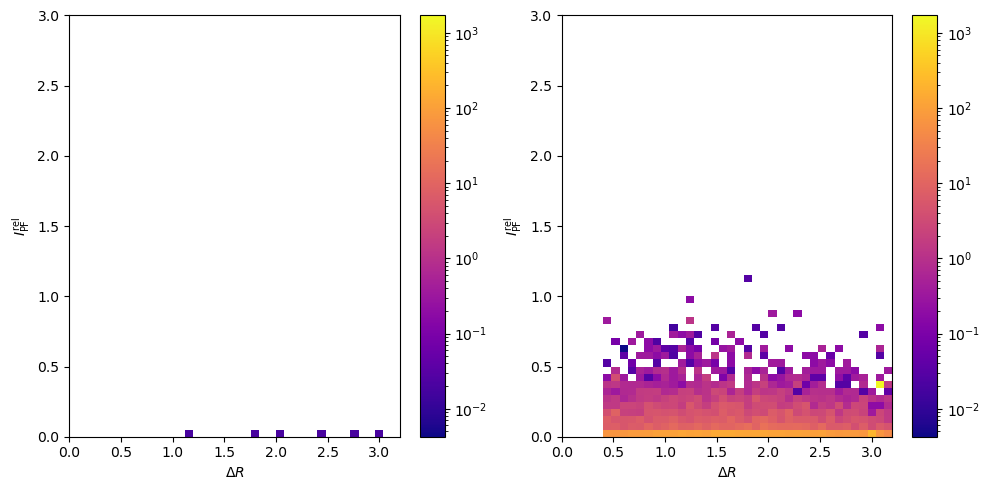

In [16]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_minEledRj_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

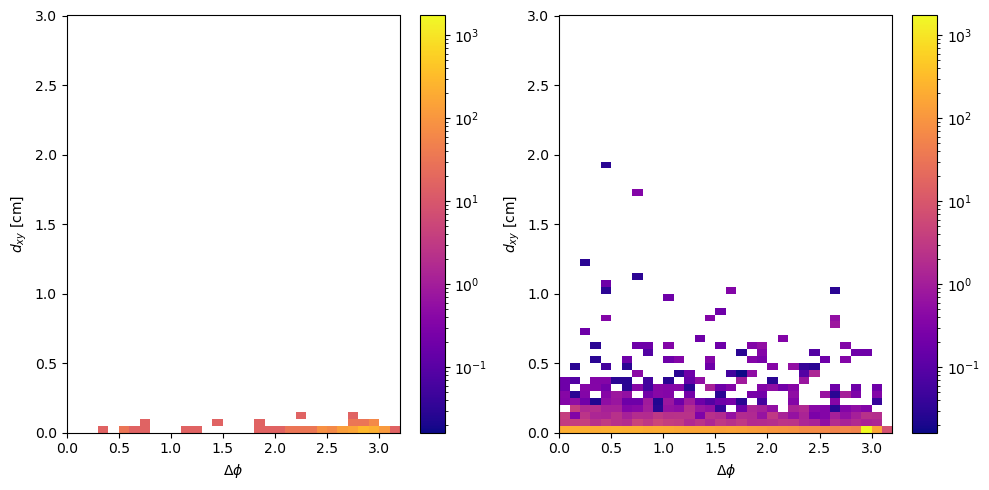

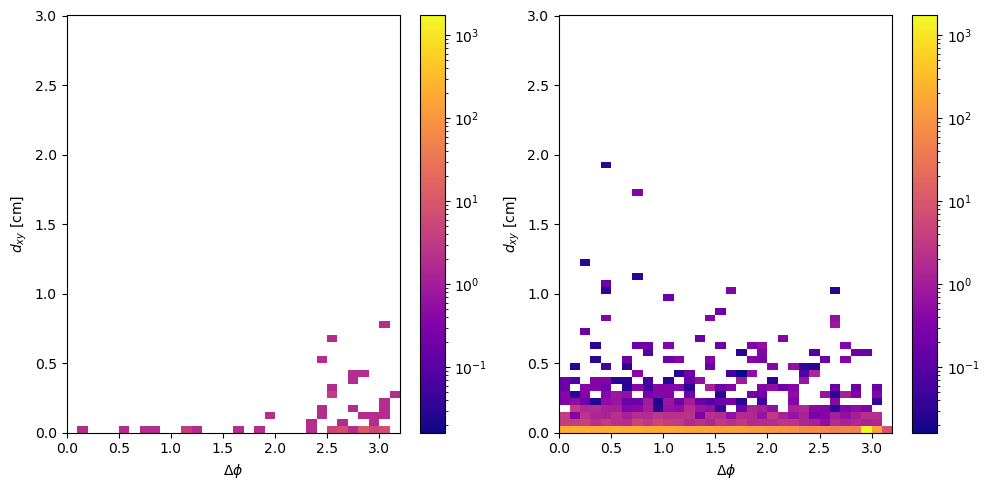

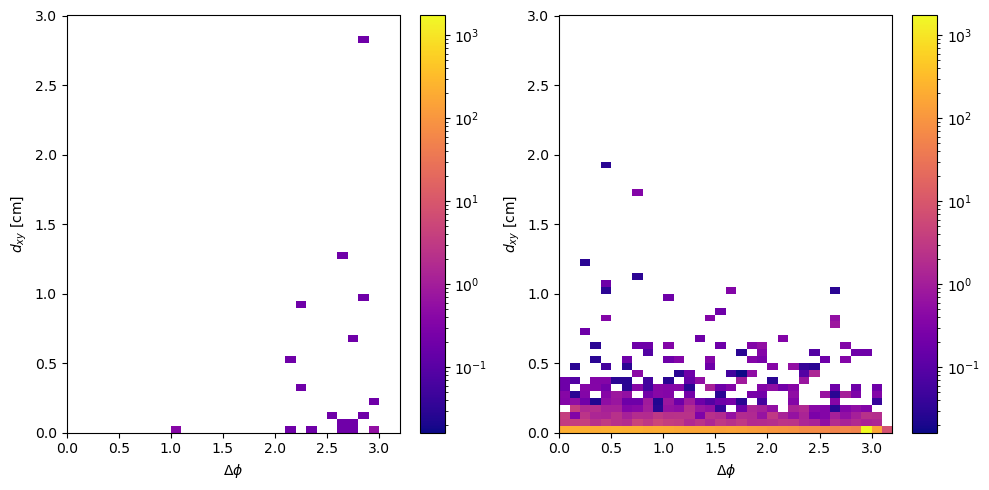

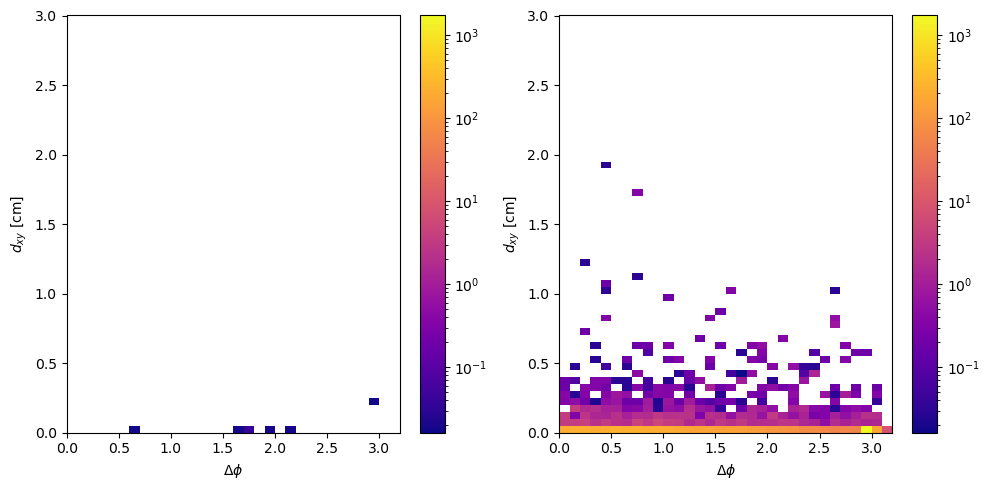

In [17]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_minEledPhiJ_vs_mindxy",2j,1j,xlim=[0,3.2],ylim=[0,3])

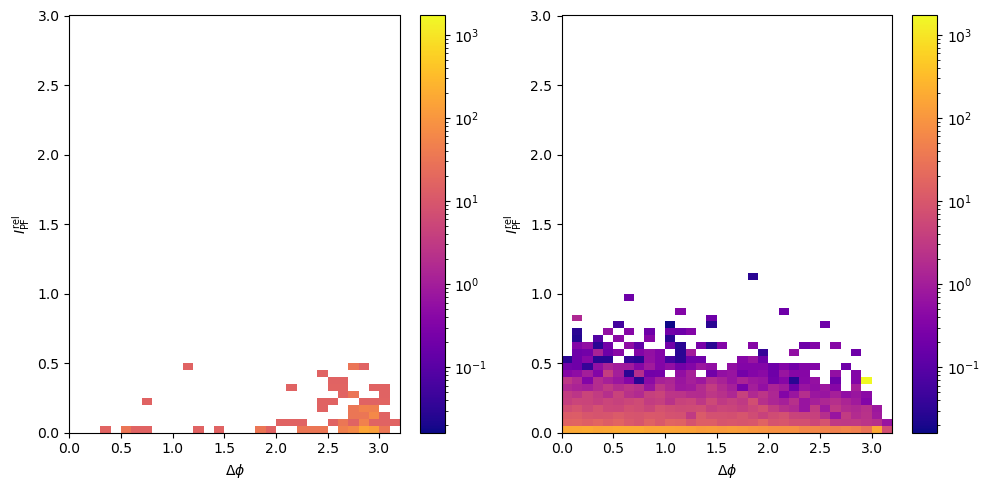

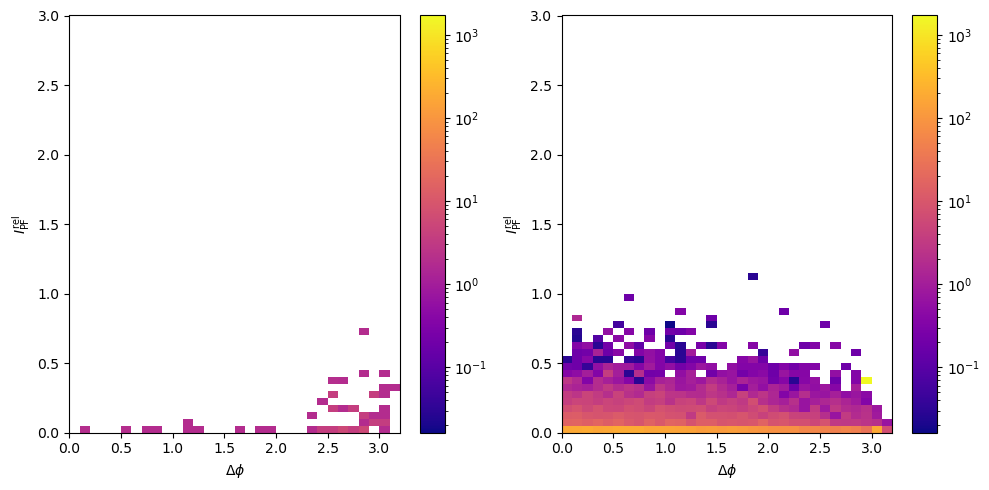

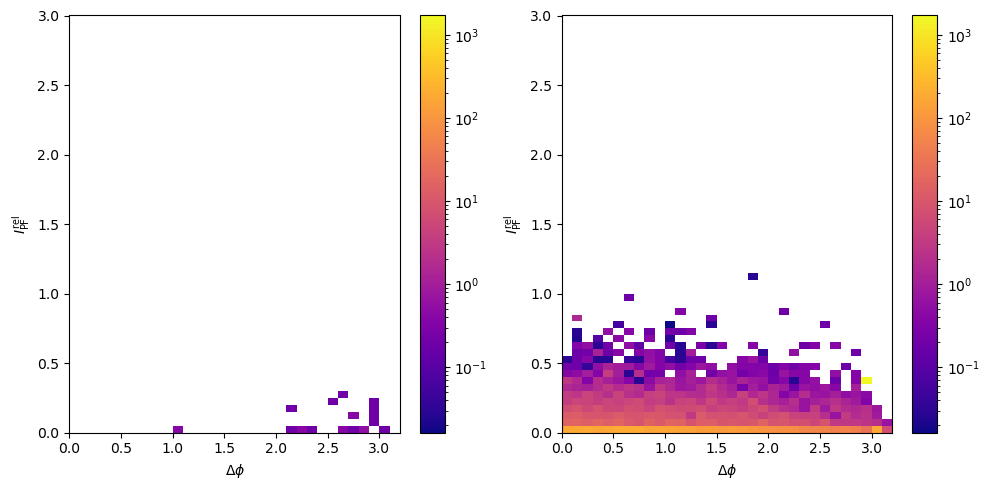

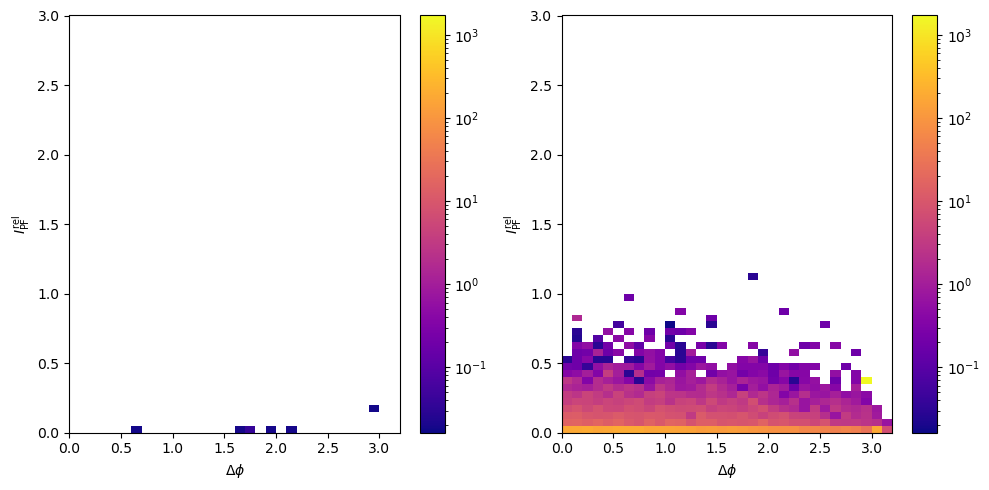

In [18]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_minEledPhiJ_vs_maxPFIso",2j,1j,xlim=[0,3.2],ylim=[0,3])

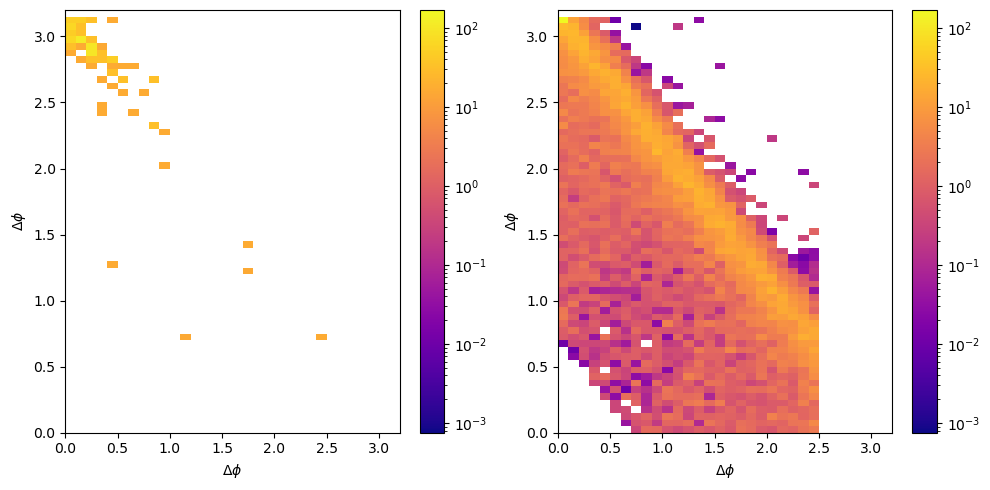

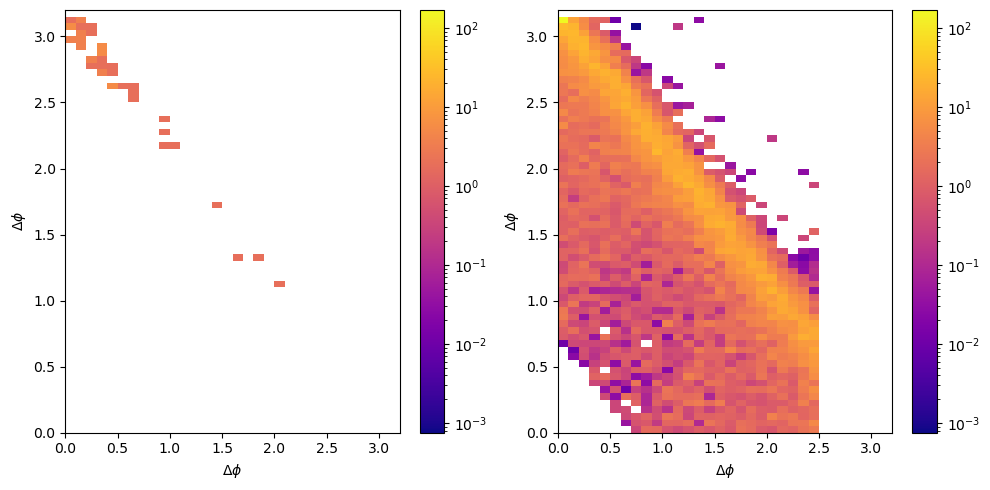

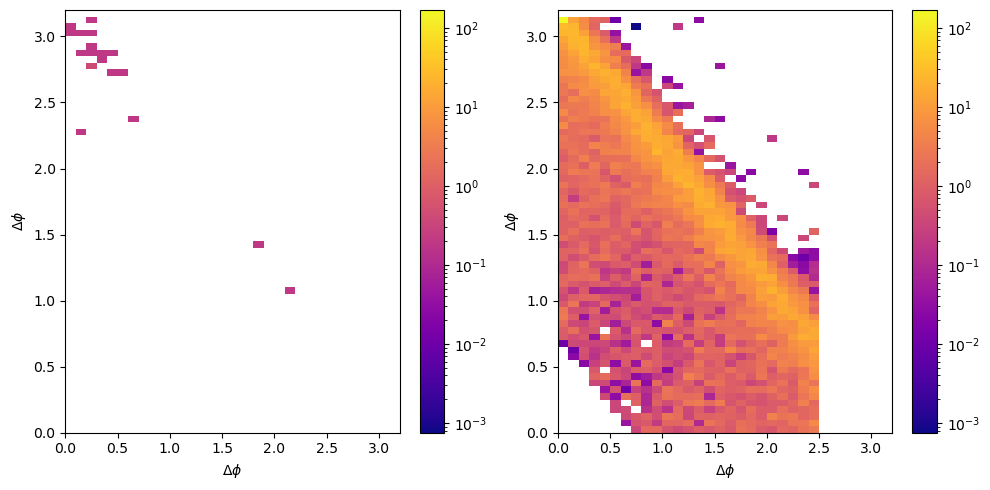

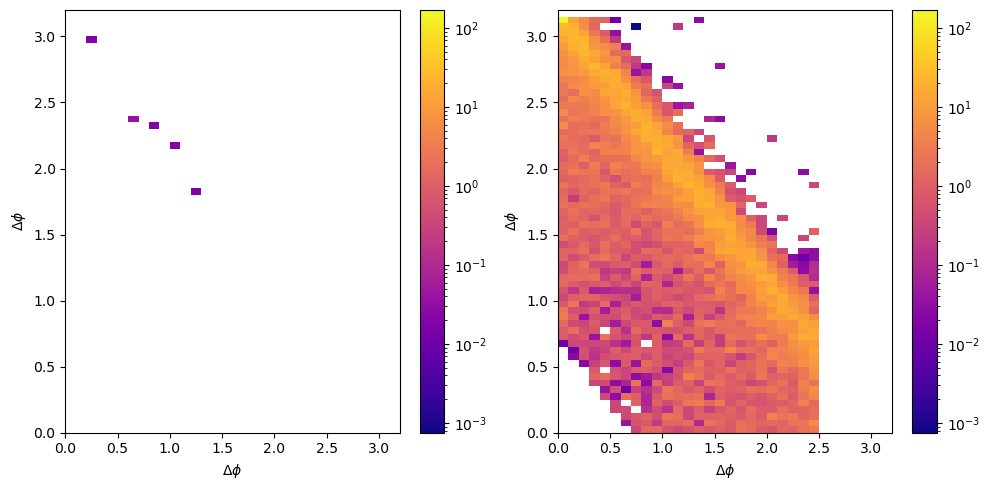

In [9]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_METdPhi_vs_mindPhiJ",2j,1j,xlim=[0,3.2],ylim=[0,3.2])

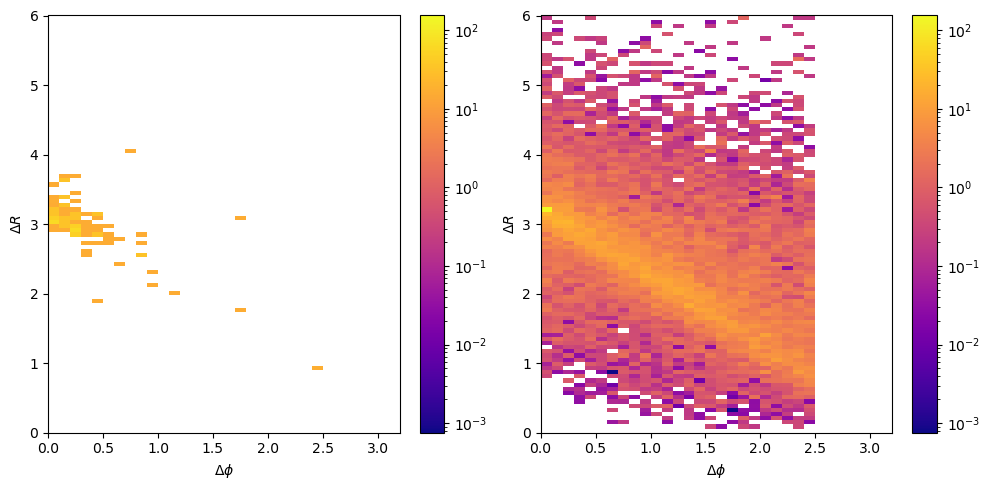

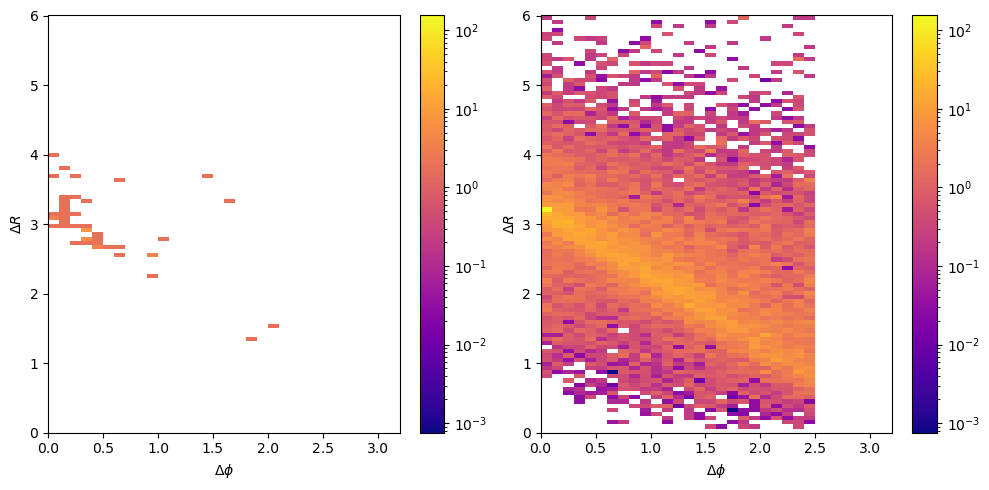

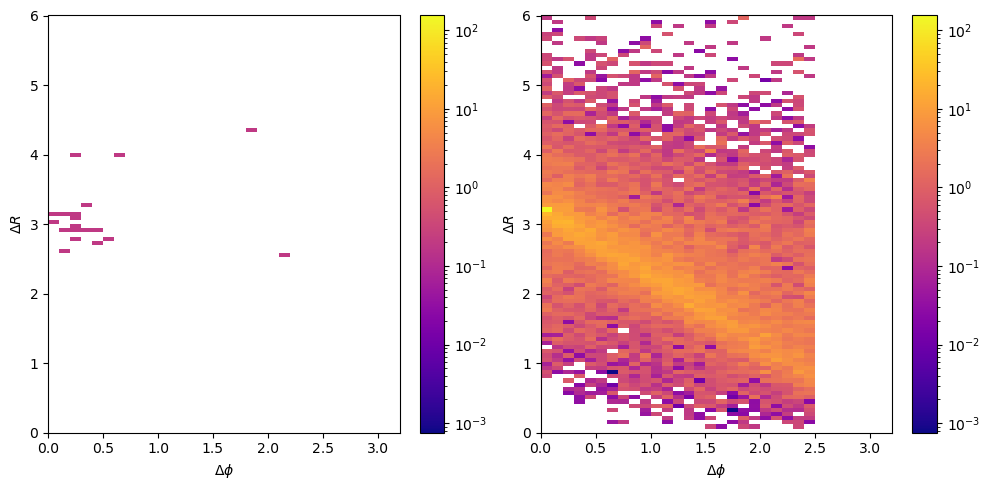

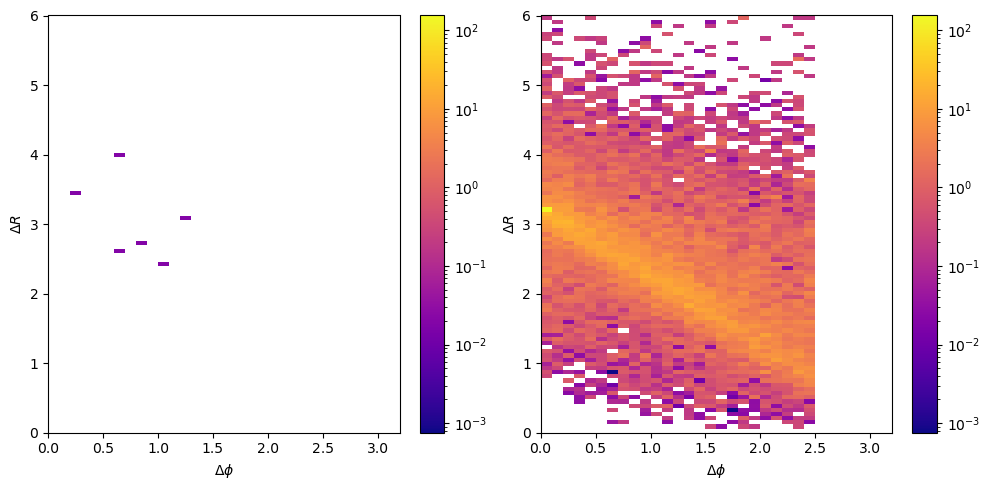

In [10]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_METdPhi_vs_mindRj",2j,1j,xlim=[0,3.2],ylim=[0,6])

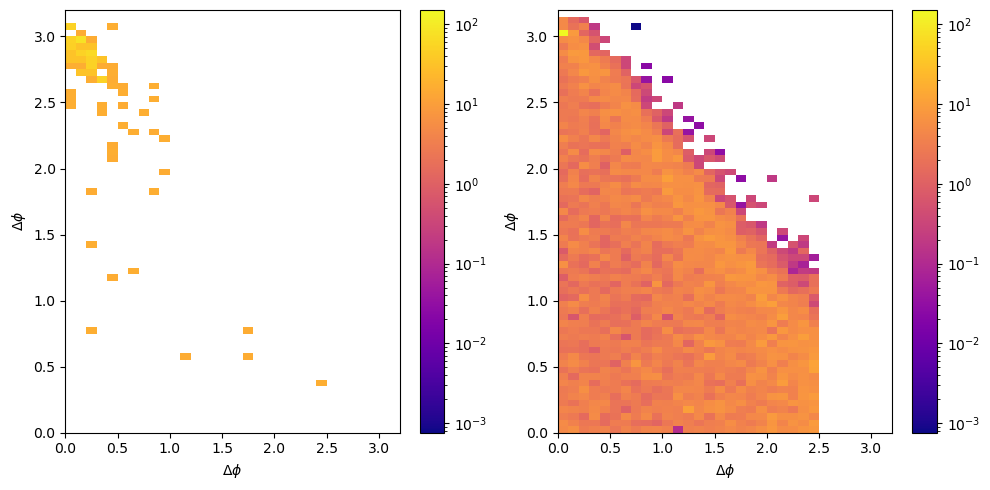

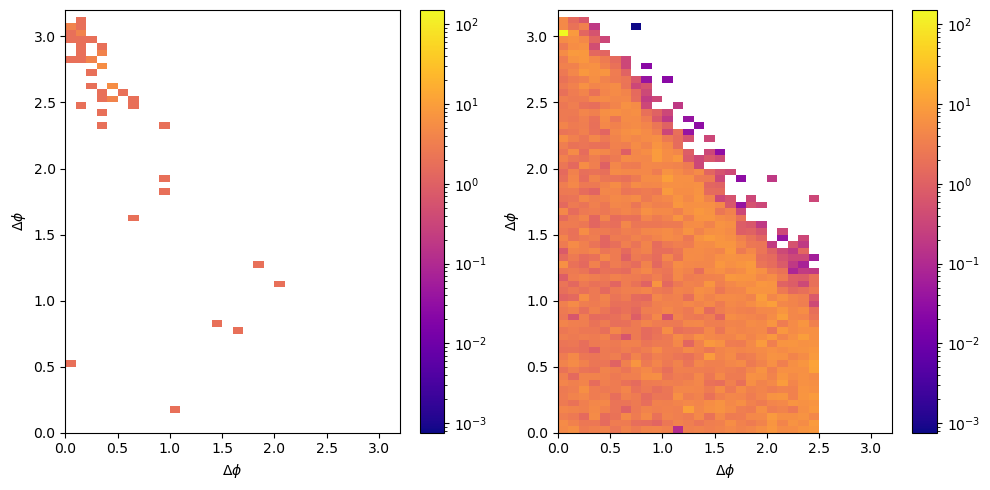

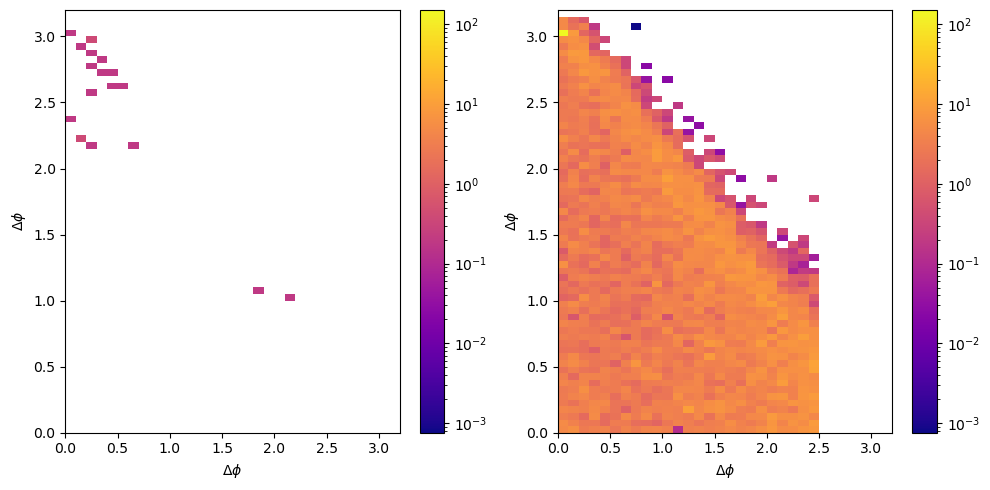

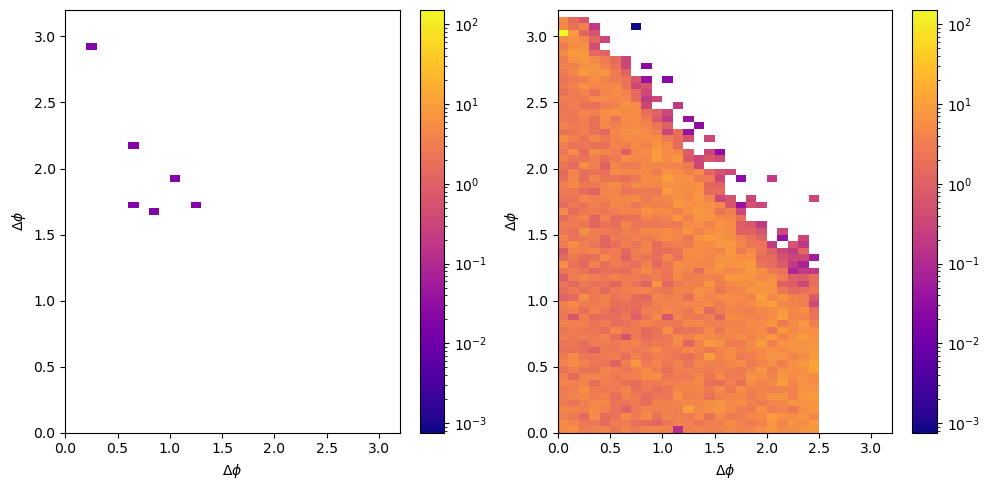

In [11]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_METdPhi_vs_minEledPhiJ",2j,1j,xlim=[0,3.2],ylim=[0,3.2])

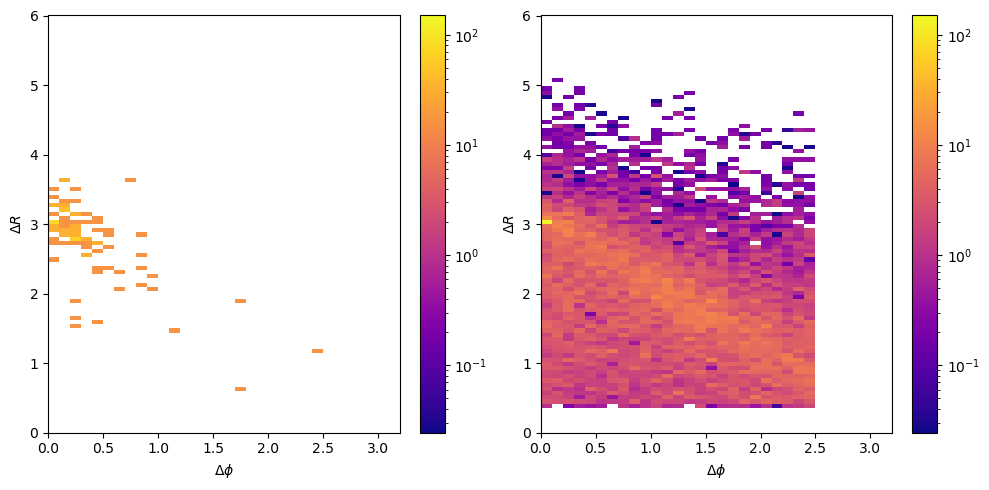

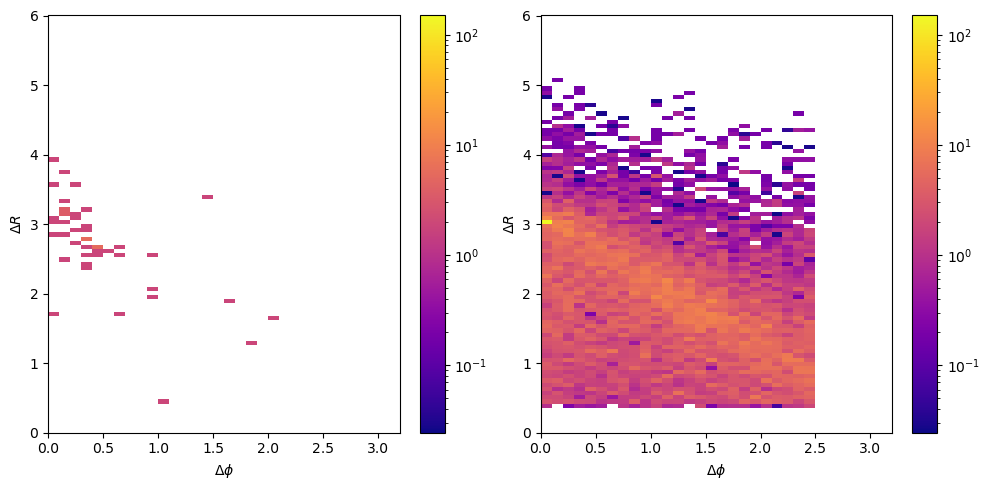

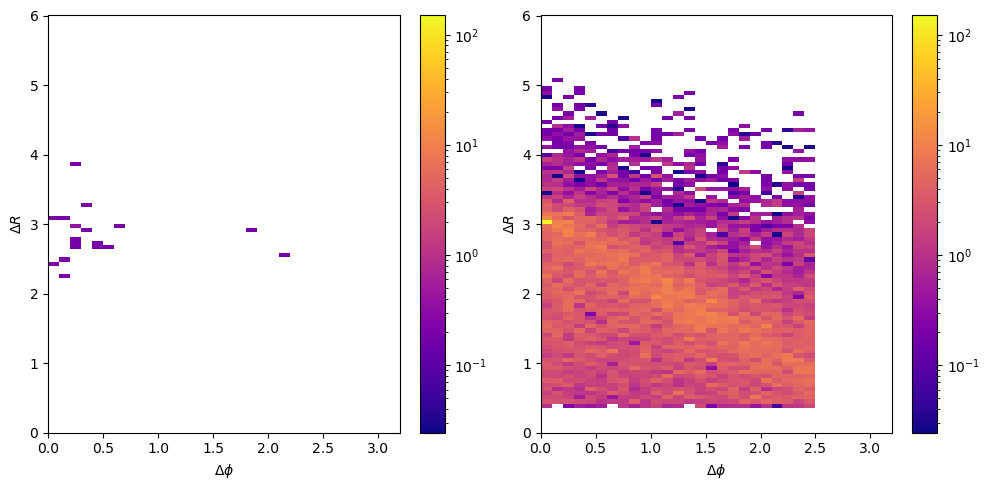

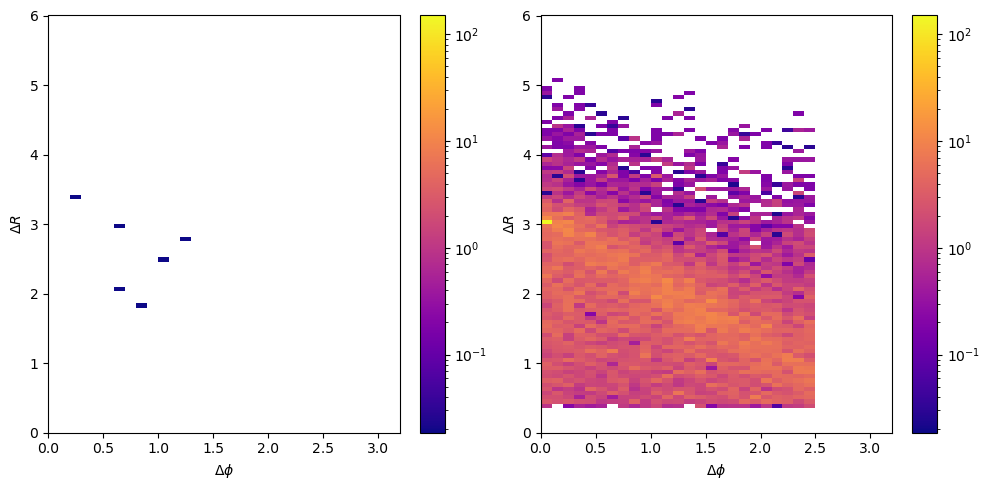

In [13]:
plot("sig_2018_Mchi-42p0_dMchi-4p0","sel_vtx_METdPhi_vs_minEledRj",2j,1j,xlim=[0,3.2],ylim=[0,6])